In [1]:
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from pathlib import Path
from PIL import Image34
import sys


In [2]:
#set cuda deivce
if t.cuda.is_available():
    dev = 'cuda:0'
else:
    dev = 'cpu'
print(device := t.device(dev))

cuda:0


In [2]:
"""
general outline

each pixel: r, g, b, 8 for prediction, 10 for information flow (21)
input: 9 x pixel, 3x3 convoltuion which is the flattened (189)
1 dense layer: 256 relu
output: 8 sigmoid
loss: cross entrpoy

general traingin methods 
20 iters of updates the pairwise cross entry of the image

model



"""

'\ngeneral outline\n\neach pixel: r, g, b, 8 for prediction, 10 for information flow (21)\ninput: 9 x pixel, 3x3 convoltuion which is the flattened\n\n\n'

In [3]:
def perceive(state):
    sobel_y = np.array([[1,2,1],
                        [0,0,0],
                        [-1, -2, -1]])
    sobel_x = sobel_y.T
    
    grad_x = cv2.filter2D(state, -1, sobel_x)
    grad_y = cv2.filter2D(state, -1, sobel_y)
    print(state.shape, grad_x.shape, grad_y.shape)
    return np.stack([state, grad_x, grad_y])

In [4]:
def mask_to_label(mask):
    colors = [(0,0,0), (0,0,1), (0,1,0), (0,1,1), 
             (1,0,0), (1,0,1), (1,1,0), (1,1,1)]
    color_to_index = dict(zip(colors, range(len(colors))))
    pix_to_index = lambda pixel: color_to_index.get(tuple([p.item() for p in pixel]))
    label_mask = t.zeros(len(colors), mask.shape[1], mask.shape[2])
    for i in range(mask.shape[1]):
        for j in range(mask.shape[2]):
            index = pix_to_index(mask[:,i,j])
            if index == None:
                print(mask[:,i,j])
            label_mask[index, i, j] = 1
    return label_mask
            

In [5]:
def init_img(img):
    state = t.zeros(27, 128,128)
    return t.cat((img, state))

In [6]:
def pred_to_mask(pred):
    colors = [(0,0,0), (0,0,1), (0,1,0), (0,1,1), 
             (1,0,0), (1,0,1), (1,1,0), (1,1,1)]
    colors = np.array(colors)
    return colors[pred.argmax(dim=0)] * 255

In [7]:
class RCN(nn.Module):
    '''
    model for recurrent convoltion network
    '''
    
    def __init__(self, kernel_amount, channels_in,
                 channels_out, prec_update):
        super(RCN, self).__init__()
        
        self.kernel_amout = kernel_amount
        self.channels_out = channels_out
        self.prec_udpate = prec_update
        self.channels_in = channels_in
        
        self.preceive = nn.Sequential(
            nn.Conv2d(channels_in, kernel_amount, 3, padding='same'),
            nn.ReLU()
        )
        
        self.chg = nn.Sequential(
            nn.Conv2d(kernel_amount, kernel_amount, 1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(kernel_amount, channels_out, 1, padding='same')
            
        )
        
        
    def update(self, x, prec_update=None):
        img, state = x[:,:3,:,:], x[:,3:,:,:]
        if prec_update == None:
            prec_update = self.prec_udpate
        ds  = self.chg.forward(self.preceive.forward(x))
        update_mask = t.rand(x.shape[-2], x.shape[-1]) <= prec_update
        ds *= update_mask
        ds = t.cat((t.zeros(1,3,128,128), ds), dim=1)
        return x + ds
    
    def classify(self, x):
        return x[:, [-i for i in list(range(1,9))[::-1]],:, :]
        
    
        

In [3]:
class Model(nn.Module):
    def __init__(self, update_mask, mini_rollout, full_rollout, learning_rate, ):
        super(Model, self).__init__()
        
        self.main_net = nn.seqientail(
            nn.Conv2d(3,48)
        )

        
        
    def update(self):

    
    def classify(self):


IndentationError: expected an indented block (411277863.py, line 10)

In [49]:
class OceanDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir, 'images')
        self.msk_dir = os.path.join(root_dir, 'masks')
        self.names = np.array([s.split('.')[0] for s in os.listdir(self.img_dir)])
        self.transform = transform
        
        
    def __len__(self):
        return len(os.listdir(self.img_dir))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.names[idx] + '.jpg')
        msk_path = os.path.join(self.msk_dir, self.names[idx] + '.bmp')
        img, msk = cv2.imread(img_path), cv2.imread(msk_path)
        
        #there is no image normalization thus far
        #I'm going to see how it works then come back
        
        #maybe I should be converting the mask into a w x h x label
        if self.transform: 
            img = cv2.cvtColor(cv2.resize(img, (128, 128)), cv2.COLOR_BGR2RGB)
            msk = cv2.cvtColor(cv2.resize(msk, (128, 128), interpolation=0), cv2.COLOR_BGR2RGB)
            img = self.transform(img)
            msk = self.transform(msk)
            msk = msk.round()
        return img, msk, mask_to_label(msk)

class OxfordPet(Dataset):
    
    def __init__(self, transform=None):
        self.dataPath = Path.cwd() / 'data' / 'OxfordPets'
        self.imgPath = self.dataPath / 'images'
        self.mskPath = self.dataPath / 'annotations' / 'trimaps'
        self.imgPaths = list(self.imgPath.glob('*.*'))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgPaths)
    
    def __getitem__(self, idx):
        img = cv2.imread(str(self.imgPaths[idx]))
        msk = cv2.imread(str(ox.mskPath / (ox.imgPaths[1].name[:-3] + 'png')))
        
        if self.transform:
            img = cv2.cvtColor(cv2.resize(img, (128, 128)), cv2.COLOR_BGR2RGB)
            msk = cv2.cvtColor(cv2.resize(msk, (128, 128), interpolation=0), cv2.COLOR_BGR2RGB)
            img = self.transform(img)
            msk = self.transform(msk)
            msk = msk.round()
        return img, msk
    
        

In [50]:
ox = OxfordPet()
print(len(ox))
img, msk = ox[1]
print(img.shape)
print(msk.shape)

7393
(500, 333, 3)
(500, 333, 3)


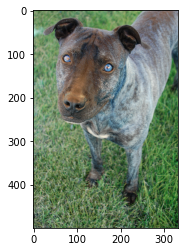

In [51]:
plt.imshow(img)

In [40]:
msk

In [3]:
datapath = Path.cwd() / 'data' / 'OxfordPets'
images = datapath / 'images'
ants = datapath / 'annotations' / 'trimaps'
image_names = list(images.glob('*.*'))
ant_names = list(ants.glob('[!.]*.*'))

In [53]:
im = Image.open(image_names[0])
im.show()

In [7]:
test = cv2.imread(str(ant_names[100]))
test1 = cv2.imread(str(image_names[100]))

In [9]:
test

array([[[3, 3, 3],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[3, 3, 3],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[3, 3, 3],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       ...,

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]]], dtype=uint8)

In [88]:
str(Path.cwd())

'/home/graham/code/Reccurent_Image_Segmentation'

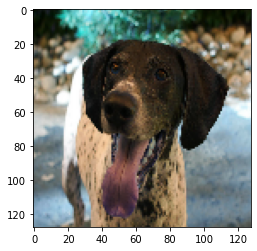

In [84]:
plt.imshow(cv2.resize(test1, (128,128)))

In [6]:
tesant_names[1]

PosixPath('/home/graham/code/Reccurent_Image_Segmentation/data/OxfordPets/annotations/trimaps/miniature_pinscher_45.png')